<a href="https://colab.research.google.com/github/kerim371/Julia-Devito-Inversion-JUDI-examples-in-Colab/blob/main/JUDI_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this notebook in Colab you either have to use this script or download it and then upload to Colab. You cannot simply copy this code and past it to your Colab session - this won't let you use Julia. You can open **.pynb** document in textual editor and see at top of the document how it Julia is et up and change its version as well if you need.

# **Julia installation**

In [1]:
# Julia installation
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

--2020-12-12 21:12:30--  https://julialang-s3.julialang.org/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz [following]
--2020-12-12 21:12:30--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.5/julia-1.5.0-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.240, 142.250.73.208, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105098627 (100M) [application/x-tar]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[========

# **Install Python and Julia packages**

Until now we have been using ipython. Now we are going to use Julia. To achieve it go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.5.0* as the runtime and *GPU* as the hadware accelerator. If necessary reload web-page (F5) and change **Notebook settings**

In [1]:
using Pkg

ENV["PYTHON"]="/root/.julia/conda/3/bin/python"
Pkg.add("PyCall")
Pkg.build("PyCall")

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
  Installed MacroTools ─ v0.5.6
  Installed PyCall ───── v1.92.1
Updating `~/.julia/environments/v1.5/Project.toml`
  [438e738f] + PyCall v1.92.1
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [1914dd2f] + MacroTools v0.5.6
  [438e738f] + PyCall v1.92.1
  [37e2e46d] + LinearAlgebra
   Building PyCall → `~/.julia/packages/PyCall/BcTLp/deps/build.log`
   Building Conda ─→ `~/.julia/packages/Conda/x5ml4/deps/build.log`
   Building PyCall → `~/.julia/packages/PyCall/BcTLp/deps/build.log`


In [2]:
Pkg.Registry.add(RegistrySpec(url="https://github.com/slimgroup/SLIMregistryJL.git"))
Pkg.develop("JUDI")

    Cloning registry from "https://github.com/slimgroup/SLIMregistryJL.git"


      Added registry `SLIMregistryJL` to `~/.julia/registries/SLIMregistryJL`


    Cloning git-repo `https://GitHub.com/slimgroup/JUDI.jl.git`


  Resolving package versions...
  Installed Adapt ──────────────────────── v2.3.0
  Installed BFloat16s ──────────────────── v0.1.0
  Installed Dierckx_jll ────────────────── v0.0.1+0
  Installed Mocking ────────────────────── v0.7.1
  Installed SpecialFunctions ───────────── v0.10.3
  Installed OrderedCollections ─────────── v1.3.2
  Installed OffsetArrays ───────────────── v1.4.1
  Installed NNlib ──────────────────────── v0.7.7
  Installed Requires ───────────────────── v1.1.1
  Installed Nullables ──────────────────── v1.0.0
  Installed IterTools ──────────────────── v1.3.0
  Installed GPUArrays ──────────────────── v6.1.2
  Installed EzXML ──────────────────────── v1.1.0
  Installed DistributedArrays ──────────── v0.6.5
  Installed TextWrap ───────────────────── v1.0.1
  Installed Dierckx ────────────────────── v0.5.1
  Installed NaNMath ────────────────────── v0.3.5
  Installed IterativeSolvers ───────────── v0.8.4
  Installed FFTW ───────────────────────── v1.2.4
  Installed Tim

    Cloning [157a0f19-4d44-4de5-a0d0-07e2f0ac4dfa] SegyIO from https://GitHub.com/slimgroup/SegyIO.jl.git


  Installed SegyIO ─────────────────────── v0.7.3
    Cloning [bb331ad6-a1cf-11e9-23da-9bcb53c69f6f] JOLI from https://GitHub.com/slimgroup/JOLI.jl.git


  Installed JOLI ───────────────────────── v0.7.13
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
Updating `~/.julia/environments/v1.5/Project.toml`
  [f3b833dc] + JUDI v2.2.0 `~/.julia/dev/JUDI`
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [621f4979] + AbstractFFTs v0.5.0
  [79e6a3ab] + Adapt v2.3.0
  [c7e460c6] + ArgParse v1.1.1
  [ab4f0b2a] + BFloat16s v0.1.0
  [fa961155] + CEnum v0.4

In [3]:
;/root/.julia/conda/3/bin/python -m pip install --upgrade pip

In [4]:
;/root/.julia/conda/3/bin/python -m pip install models

ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [5]:
;/root/.julia/conda/3/bin/python -m pip install devito

  Created wheel for cgen: filename=cgen-2020.1-py3-none-any.whl size=15824 sha256=fd5c793d44061db1f266b349b9e44dc21bed9c07d0a741d17bf610ae88a58a3d
  Stored in directory: /root/.cache/pip/wheels/f1/7c/34/5ea06ad75758a23a959da1268dad81f7e1191b424fb4318dd2
  Created wheel for codepy: filename=codepy-2019.1-py3-none-any.whl size=19314 sha256=c857bebf5278a2aeb672b86ffa19ea34c2118f1baba11d594a0a67e2a479242e
  Stored in directory: /root/.cache/pip/wheels/42/1f/3f/8c9d6eff98b2bacbf45771a1764eb26881c2d88c5d4e0ec75d
  Created wheel for psutil: filename=psutil-5.7.3-cp38-cp38-linux_x86_64.whl size=285844 sha256=71c3b6f55a6d52eb0a0c3afbb63340b04a285ec4572bf49843a085fa43165aac
  Stored in directory: /root/.cache/pip/wheels/f6/59/c2/38111ef4c354088a156bc95fbeb5396c0cac91a0f62f7158b9
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-py3-none-any.whl size=20069 sha256=eb61aeb051f44270e47972a3f4b055041ed2732e4973c6403e5adf1796913926
  Stored in directory: /root/.cache/pip/wheels/b4/99/9f/8eb77f

In [6]:
;/root/.julia/conda/3/bin/python -m pip install matplotlib

In [7]:
;git clone https://github.com/slimgroup/JUDI.jl

Cloning into 'JUDI.jl'...


In [8]:
cd("JUDI.jl")

In [9]:
;git checkout v2.2.0

Note: checking out 'v2.2.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at de72831 Merge pull request #35 from slimgroup/twri


In [10]:
cd("/content/JUDI.jl")
pwd()

"/content/JUDI.jl"

In [11]:
include("deps/install_global.jl")
#!julia --project -e 'using Pkg;Pkg.test(coverage=false)' # uncomment this if you want to run test

    Cloning git-repo `https://github.com/JuliaLang/TOML.jl.git`


   Updating git-repo `https://github.com/JuliaLang/TOML.jl.git`


  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [fa267f1f] + TOML v1.0.1 `https://github.com/JuliaLang/TOML.jl.git#master`
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [fa267f1f] + TOML v1.0.1 `https://github.com/JuliaLang/TOML.jl.git#master`
┌ Info: Precompiling TOML [fa267f1f-6049-4f14-aa54-33bafae1ed76]
└ @ Base loading.jl:1278
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [c7e460c6] + ArgParse v1.1.1
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [44cfe95a] + Pkg
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [10745b16] + Statistics
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [8dfed614] + Test
No Changes to `~/.juli

JUDI dependencies

In [12]:
# IO
Pkg.add("HDF5")
Pkg.add("JLD")
Pkg.add("JLD2")

# Plotting
Pkg.add("PyPlot")

# Optimization
Pkg.add("NLopt")
Pkg.add("IterativeSolvers")
Pkg.add("Optim")
Pkg.add("LineSearches")
Pkg.add("SetIntersectionProjection")

  Resolving package versions...
  Installed LibSSH2_jll ─ v1.9.0+3
  Installed Blosc_jll ─── v1.14.3+1
  Installed HDF5_jll ──── v1.12.0+1
  Installed HDF5 ──────── v0.14.3
  Installed OpenSSL_jll ─ v1.1.1+6
  Installed LibCURL_jll ─ v7.70.0+2
  Installed Zstd_jll ──── v1.4.5+2
  Installed nghttp2_jll ─ v1.40.0+2
  Installed Lz4_jll ───── v1.9.2+2
  Installed Blosc ─────── v0.7.0
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
######################################################################### 100.0%
##################################################

    Cloning [335f7d24-6316-57dd-9c3a-df470f2b739e] SetIntersectionProjection from https://GitHub.com/slimgroup/SetIntersectionProjection.jl.git


  Installed SetIntersectionProjection ─ v0.1.0
Updating `~/.julia/environments/v1.5/Project.toml`
  [335f7d24] + SetIntersectionProjection v0.1.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [13072b0f] + AxisAlgorithms v1.0.0
  [a98d9a8b] + Interpolations v0.13.1
  [c84ed2f1] + Ratios v0.4.0
  [335f7d24] + SetIntersectionProjection v0.1.0
  [efce3f68] + WoodburyMatrices v0.5.3


# **JUDI examples**

## Script examples

### *extended_source_lsqr.jl*

In [ ]:
;cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [ ]:
# Example for basic 2D modeling:
# The receiver positions and the source wavelets are the same for each of the four experiments.
# Author: Philipp Witte, pwitte@eos.ubc.ca
# Date: January 2017
#

using JUDI.TimeModeling, SegyIO, LinearAlgebra, PyPlot, IterativeSolvers, JOLI

# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.4f0
v[:,Int(round(end/2)):end] .= 5f0

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2

# Setup info and model structure
nsrc = 1	# number of sources
model = Model(n, d, o, m)

# Set up receiver geometry
nxrec = 120
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = 0f0
zrec = range(50f0, stop=50f0, length=nxrec)

# receiver sampling and recording time
time = 2000f0   # receiver recording time [ms]
dt = 4f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=nsrc)

# Source wavelet
f0 = 0.01f0     # MHz
wavelet = ricker_wavelet(time, dt, f0)

# Set up info structure for linear operators
ntComp = get_computational_nt(recGeometry, model)
info = Info(prod(n), nsrc, ntComp)

┌ Info: Precompiling JUDI [f3b833dc-6b2e-5b9c-b940-873ed6319979]
└ @ Base loading.jl:1278


######################################################################### 100.0%


######################################################################### 100.0%


######################################################################### 100.0%


┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


Info(12000, 1, Any[2646])

=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
 

Operator `forward` run in 0.17 s
Operator `adjoint` run in 0.17 s


 1	2.25e+04	6.10e-01	2.27e-02	6.41e-01
 

Operator `forward` run in 0.16 s
Operator `adjoint` run in 0.17 s
Operator `forward` run in 0.17 s
Operator `adjoint` run in 0.16 s


 2	1.76e+04	2.92e-01	8.59e-03	5.03e-01



Operator `forward` run in 0.16 s
Operator `adjoint` run in 0.17 s


=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	1.97e+04	6.95e-01	8.12e-03	5.91e-01
 

Operator `forward` run in 0.16 s
Operator `adjoint` run in 0.17 s
Operator `forward` run in 0.16 s
Operator `adjoint` run in 0.18 s


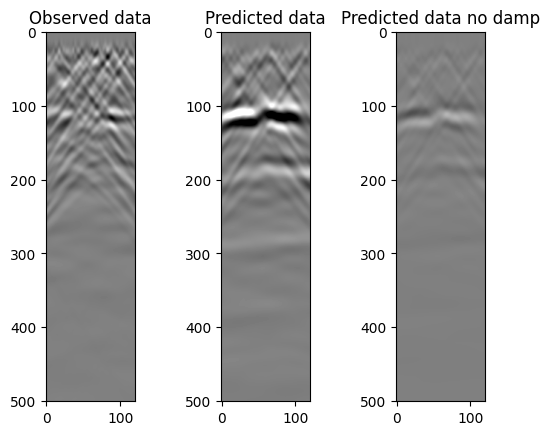

 2	1.96e+04	6.54e-01	7.07e-04	5.88e-01



Operator `forward` run in 0.16 s
Operator `adjoint` run in 0.17 s
Operator `forward` run in 0.16 s
Operator `forward` run in 0.16 s


PyObject Text(0.5, 1.0, 'Predicted data no damp')

In [ ]:
###################################################################################################

# Write shots as segy files to disk
opt = Options()

# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model; options=opt)

# Random weights (size of the model)
w = judiWeights(randn(Float32, model.n))

# Create operator for injecting the weights, multiplied by the provided wavelet(s)
Pw = judiLRWF(info, wavelet)

# Model observed data w/ extended source
lambda = 1f2
I = joDirac(info.n, DDT=Float32, RDT=Float32)
F = Pr*F*adjoint(Pw)
F̄ = [F; lambda*I]

# Simultaneous observed data
d_sim = F*w

# # Adjoint operation
w_adj = adjoint(F)*d_sim

# # LSQR
w_inv = 0f0 .* w
w_inv_no_damp = 0f0 .* w
lsqr!(w_inv, F̄, [d_sim; lambda*w]; maxiter=2, verbose=true, damp=1e2)
lsqr!(w_inv_no_damp, F, d_sim; maxiter=2, verbose=true, damp=1e2)

d_pred = F*w_inv;
d_pred_no_damp = F*w_inv_no_damp;

# Plot results
figure()
subplot(1,3,1)
imshow(d_sim.data[1], vmin=-5e2, vmax=5e2, cmap="gray"); title("Observed data")
subplot(1,3,2)
imshow(d_pred.data[1], vmin=-2e2, vmax=2e2, cmap="gray"); title("Predicted data")
subplot(1,3,3)
imshow(d_pred_no_damp.data[1], vmin=-2e2, vmax=2e2, cmap="gray"); title("Predicted data no damp")

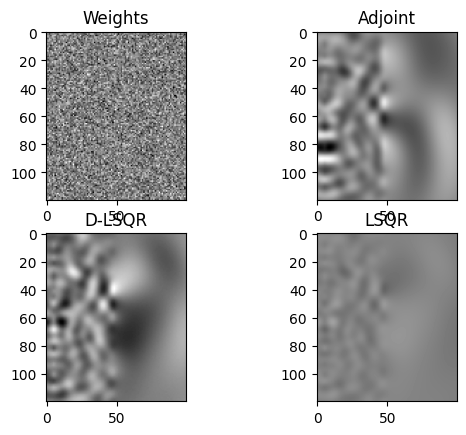

PyObject Text(0.5, 1.0, 'LSQR')

In [ ]:
figure()
subplot(2,2,1)
imshow(w.weights[1], vmin=-3, vmax=3, cmap="gray"); title("Weights")
subplot(2,2,2)
imshow(w_adj.weights[1], vmin=minimum(w_adj), vmax=maximum(w_adj), cmap="gray"); title("Adjoint")
subplot(2,2,3)
imshow(w_inv.weights[1], vmin=minimum(w_inv), vmax=maximum(w_inv), cmap="gray"); title("D-LSQR")
subplot(2,2,4)
imshow(w_inv_no_damp.weights[1], vmin=minimum(w_inv), vmax=maximum(w_inv), cmap="gray"); title("LSQR")

### *fwi_example_2D.jl*

In [13]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [14]:
# 2D FWI on Overthrust model using minConf library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, LinearAlgebra
using JUDI.TimeModeling, JUDI.SLIM_optim, HDF5, SegyIO, PyPlot

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)
vmin = ones(Float32,model0.n) .* 1.3f0
vmax = ones(Float32,model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21]

# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

┌ Info: Precompiling JUDI [f3b833dc-6b2e-5b9c-b940-873ed6319979]
└ @ Base loading.jl:1278


######################################################################### 100.0%


######################################################################### 100.0%


######################################################################### 100.0%


┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1278
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [15]:
############################### FWI ###########################################

# Optimization parameters
niterations = 10
batchsize = 16
fhistory_SGD = zeros(Float32,niterations)

# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)

# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0,q[i],d_obs[i])
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

	# linesearch
	step = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, proj; alpha=1f0)

	# Update model and bound projection
	model0.m = proj(model0.m + reshape(step,model0.n))
end

FWI iteration no: 1; function value: 542631.25


Operator `forward` run in 0.29 s
Operator `gradient` run in 0.32 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.27 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.32 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.

LoadError: ignored

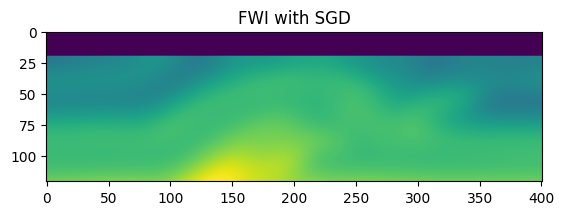

PyObject Text(0.5, 1.0, 'FWI with SGD')

In [16]:
figure(); imshow(sqrt.(1f0./adjoint(model0.m))); title("FWI with SGD")

### *fwi_example_NLopt.jl*

In [ ]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [ ]:
# 2D FWI on Overthrust model with L-BFGS using NLopt library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, LinearAlgebra
using JUDI.TimeModeling, HDF5, NLopt, SegyIO

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)
vmin = ones(Float32, model0.n) .* 1.3f0
vmax = ones(Float32, model0.n) .* 6.5f0

# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0)    # 8 Hz wavelet
q = judiVector(src_geometry, wavelet)

┌ Info: Precompiling NLopt [76087f3c-5699-56af-9a33-bf431cd00edd]
└ @ Base loading.jl:1278
┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [ ]:
############################### FWI ###########################################

# optimization parameters
batchsize = 16
count = 0

# NLopt objective function
println("No.  ", "fval         ", "norm(gradient)")
function f!(x,grad)

    # Update model
    model0.m = convert(Array{Float32, 2}, reshape(x, model0.n))

    # Seclect batch and calculate gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])

    # Reset gradient in water column to zero
    gradient = reshape(gradient, model0.n)
    gradient[:, 1:21] .= 0f0
    grad[1:end] = vec(gradient)

    global count; count += 1
    println(count, "    ", fval, "    ", norm(grad))
    return convert(Float64, fval)
end

No.  fval         norm(gradient)


f! (generic function with 1 method)

In [ ]:
# Optimization parameters
opt = Opt(:LD_LBFGS, prod(model0.n))
lower_bounds!(opt, mmin); upper_bounds!(opt, mmax)
min_objective!(opt, f!)
maxeval!(opt, 10)
(minf, minx, ret) = optimize(opt, vec(model0.m))

(0.0, [0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136, 0.4444444477558136  …  0.05520664155483246, 0.05520186200737953, 0.05519702658057213, 0.055192138999700546, 0.05518719553947449, 0.05518219247460365, 0.055177122354507446, 0.05517197772860527, 0.055166758596897125, 0.05516145005822182], :FORCED_STOP)

### *fwi_example_constraints.jl*

In [ ]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [ ]:
# 2D FWI on Overthrust model using minConf library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, Pkg
using LinearAlgebra
using JUDI.TimeModeling, JUDI.SLIM_optim, HDF5, SegyIO, PyPlot, FFTW
using SetIntersectionProjection

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

┌ Info: Precompiling SetIntersectionProjection [335f7d24-6316-57dd-9c3a-df470f2b739e]
└ @ Base loading.jl:1278
┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [ ]:
############################### FWI ###########################################

# Optimization parameters
niterations = 10
batchsize = 10
fhistory_SGD = zeros(Float32,niterations)


########## Setup constraints
# with constraints:
options=PARSDMM_options()
options.FL=Float32
options=default_PARSDMM_options(options,options.FL)
options.adjust_gamma = true
options.adjust_rho = true
options.adjust_feasibility_rho = true
options.Blas_active = true
options.maxit = 1000
options.feas_tol = 0.001
options.obj_tol = 0.001
options.evol_rel_tol = 0.00001

options.rho_ini=[1.0f0]

set_zero_subnormals(true)
BLAS.set_num_threads(2)
FFTW.set_num_threads(2)
options.parallel=false
options.feasibility_only = false
options.zero_ini_guess=true

constraint = Vector{SetIntersectionProjection.set_definitions}()

#bounds:
vmin = ones(Float32,model0.n) .* 1.3f0
vmax = ones(Float32,model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21]

# Slowness squared [s^2/km^2]
m_min = vec((1f0 ./ vmax).^2)
m_max = vec((1f0 ./ vmin).^2)
set_type = "bounds"
TD_OP = "identity"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#TV
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options.FL)
m_min = 0.0
m_max = norm(TV*vec(v0),1) *2.0f0
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#set up constraints, precompute some things and define projector
(P_sub,TD_OP,set_Prop) = setup_constraints(constraint,model0,options.FL)
(TD_OP,AtA,l,y) = PARSDMM_precompute_distribute(TD_OP,set_Prop,model0,options)
options.rho_ini = ones(length(TD_OP))*10.0

proj_intersection = x-> PARSDMM(x, AtA, TD_OP, set_Prop, P_sub, model0, options)  

function prj(input)
    input = Float32.(input)
    (x,dummy1,dummy2,dymmy3) = proj_intersection(vec(input))
    return reshape(x, model0.n)
end

########## Run

# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0,q[i],d_obs[i])
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    step = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, prj; alpha=1f0)

    # Update model and bound projection
    model0.m = prj(model0.m + reshape(step,model0.n))
end

FWI iteration no: 1; function value: 345744.47


Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s


LoadError: ignored

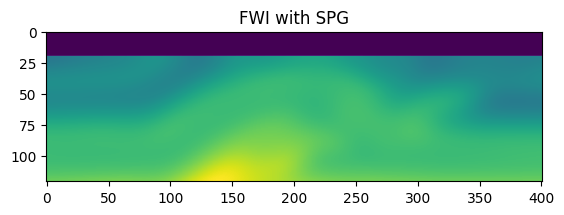

PyObject Text(0.5, 1.0, 'FWI with SPG')

In [ ]:
figure(); imshow(sqrt.(1f0./adjoint(model0.m))); title("FWI with SPG")

### *fwi_example_minConf.jl*

In [ ]:
; cd /content/JUDI.jl/examples/scripts

In [ ]:
# 2D FWI on Overthrust model with SPG using minConf library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, LinearAlgebra, PyPlot
using JUDI.TimeModeling, JUDI.SLIM_optim, HDF5, SegyIO

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1f0 ./ model0.m)
vmin = ones(Float32,model0.n) .* 1.3f0
vmax = ones(Float32,model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21]

# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [ ]:
############################### FWI ###########################################

# Optimization parameters
fevals = 16
batchsize = 8

# Objective function for minConf library
count = 0
function objective_function(x)
    model0.m = reshape(x,model0.n);

    # fwi function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, grad = fwi_objective(model0, q[i], d_obs[i])
    grad = .125f0*grad/maximum(abs.(grad))  # scale for line search

    global count; count+= 1
    return fval, vec(grad)
end

# Bound projection
ProjBound(x) = median([mmin x mmax]; dims=2)

# FWI with SPG
options = spg_options(verbose=3, maxIter=fevals, memory=3)
sol = minConf_SPG(objective_function, vec(model0.m), ProjBound, options)

LoadError: ignored

In [ ]:
# Plot result
imshow(reshape(sqrt.(1f0 ./ sol.sol), model0.n)', extent=[0, 10, 3, 0])
xlabel("Lateral position [km]")
ylabel("Depth [km]")

### *fwi_gauss_newton.jl*

In [17]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [18]:
# FWI on Overthrust model using minConf library
# Author: Philipp Witte, pwitte@eoas.ubc.ca
# Date: December 2017
#

using Statistics, Random, LinearAlgebra
using JUDI.TimeModeling, JUDI.SLIM_optim, HDF5, SegyIO, PyPlot, IterativeSolvers

# Load starting model
n,d,o,m0 = read(h5open("../../data/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

# Bound constraints
v0 = sqrt.(1 ./ model0.m)
vmin = ones(Float32,model0.n) .* 1.3f0
vmax = ones(Float32,model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21]

# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2)

# Load data
block = segy_read("../../data/overthrust_shot_records.segy")
d_obs = judiVector(block)

# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /root/.julia/packages/SegyIO/uw4ZW/src/read/read_file.jl:26


judiVector{Float32}("Seismic data vector", 8016, 1, 16, GeometryIC(Any[400.0f0, 1013.333f0, 1626.667f0, 2240.0f0, 2853.333f0, 3466.666f0, 4080.0f0, 4693.334f0, 5306.666f0, 5920.0f0, 6533.334f0, 7146.666f0, 7760.0f0, 8373.333f0, 8986.667f0, 9600.0f0], Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], Any[50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0, 50.0f0], Any[4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0, 4.0f0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0, 2000.0f0]), Array[Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00096925104; -0.0016848503; … ; -0.0; -0.0], Float32[-0.00

In [19]:
############################### FWI ###########################################

# Set up operators
ntComp = get_computational_nt(q.geometry,d_obs.geometry,model0) # no. of computational time steps
info = Info(prod(model0.n),d_obs.nsrc,ntComp)
Pr = judiProjection(info,d_obs.geometry)
Ps = judiProjection(info,q.geometry)
F = judiModeling(info,model0)
J = judiJacobian(Pr*F*Ps',q)

# Optimization parameters
maxiter = 10
maxiter_GN = 5
fhistory_GN = zeros(Float32,maxiter)
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)],2),model0.n)

# Gauss-Newton method
for j=1:maxiter
    println("Iteration: ",j)

    # # Model predicted data for subset of sources
    d_pred = Pr*F*Ps'*q
    fhistory_GN[j] = .5f0*norm(d_pred - d_obs)^2

    # GN update direction
    p = lsqr(J, d_pred - d_obs; maxiter=maxiter_GN, verbose=true)

    # update model and bound constraints
    model0.m = proj(model0.m - reshape(p, model0.n))  # alpha=1
end

Iteration: 1


Operator `forward` run in 0.20 s
Operator `forward` run in 0.19 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.19 s
Operator `forward` run in 0.19 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.18 s
Operator `forward` run in 0.19 s


=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm


Operator `forward` run in 0.28 s
Operator `gradient` run in 0.31 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.31 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.

  1	

Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.27 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.

9.10e+02	5.37e-01	1.22e-01	8.73e-01


Operator `born` run in 0.42 s
Operator `born` run in 0.42 s
Operator `born` run in 0.41 s
Operator `born` run in 0.41 s
Operator `born` run in 0.41 s
Operator `born` run in 0.41 s
Operator `born` run in 0.41 s
Operator `born` run in 0.44 s
Operator `born` run in 0.42 s
Operator `born` run in 0.41 s
Operator `born` run in 0.41 s
Operator `born` run in 0.42 s
Operator `born` run in 0.43 s
Operator `born` run in 0.40 s
Operator `born` run in 0.41 s
Operator `born` run in 0.41 s


  2	8.09e+02	2.00e-01	1.60e-02	7.77e-01


Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.31 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.

  3	7.61e+02	1.78e-01	8.10e-03	7.31e-01


Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.27 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.

  4	7.13e+02	8.97e-02	5.20e-03	6.84e-01


Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.31 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.27 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.27 s
Operator `gradient` run in 0.

  5	6.99e+02	6.78e-02	3.92e-03	6.71e-01



Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.29 s
Operator `forward` run in 0.28 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.30 s
Operator `forward` run in 0.29 s
Operator `gradient` run in 0.

LoadError: ignored

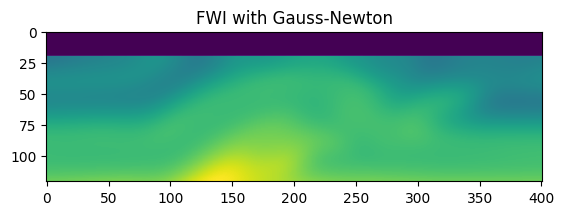

PyObject Text(0.5, 1.0, 'FWI with Gauss-Newton')

In [20]:
figure(); imshow(sqrt.(1f0./model0.m)'); title("FWI with Gauss-Newton")

### *modeling_basic_2D.jl*

In [21]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [22]:
# Example for basic 2D modeling:
# The receiver positions and the source wavelets are the same for each of the four experiments.
# Author: Philipp Witte, pwitte@eos.ubc.ca
# Date: January 2017
#

using JUDI.TimeModeling, SegyIO, LinearAlgebra

# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.5f0
v0 = ones(Float32,n) .+ 0.5f0
v[:,Int(round(end/2)):end] .= 3.5f0
rho = (v0 .+ .5f0) ./ 2

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m - m0)

# Setup info and model structure
nsrc = 2	# number of sources
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0)

# Set up receiver geometry
nxrec = 120
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = 0f0
zrec = range(50f0, stop=50f0, length=nxrec)

# receiver sampling and recording time
timeR = 1000f0   # receiver recording time [ms]
dtR = 2f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtR, t=timeR, nsrc=nsrc)

# Set up source geometry (cell array with source locations for each shot)
xsrc = convertToCell(range(400f0, stop=800f0, length=nsrc))
ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc))
zsrc = convertToCell(range(200f0, stop=200f0, length=nsrc))

# source sampling and number of time steps
timeS = 1000f0  # ms
dtS = 2f0   # ms

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtS, t=timeS)

# setup wavelet
f0 = 0.01f0     # MHz
wavelet = ricker_wavelet(timeS, dtS, f0)
q = judiVector(srcGeometry, wavelet)

# Set up info structure for linear operators
ntComp = get_computational_nt(srcGeometry, recGeometry, model)
info = Info(prod(n), nsrc, ntComp)

Info(12000, 2, Any[926, 926])

In [23]:
###################################################################################################

# Write shots as segy files to disk
opt = Options(optimal_checkpointing=false, isic=false, subsampling_factor=2, dt_comp=1.0)

# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model; options=opt)
F0 = judiModeling(info, model0; options=opt)
Ps = judiProjection(info, srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

# Nonlinear modeling
dobs = Pr*F*adjoint(Ps)*q
# # Adjoint
qad = Ps*adjoint(F)*adjoint(Pr)*dobs

# Linearized modeling
dD = J*dm
# Adjoint jacobian
rtm = adjoint(J)*dD

# evaluate FWI objective function
f, g = fwi_objective(model0, q, dobs; options=opt)

# TWRI
f, gm, gy = twri_objective(model0, q, dobs, nothing; options=opt, optionswri=TWRIOptions(params=:all))

# evaluate LSRTM objective function
fj, gj = lsrtm_objective(model0, q, dD, dm; options=opt)
fjn, gjn = lsrtm_objective(model0, q, dobs, dm; nlind=true, options=opt)

# By extension, lsrtm_objective is the same as fwi_objecive when `dm` is zero
# And with computing of the residual. Small noise can be seen in the difference
# due to floating point roundoff errors with openMP, but running with 
# OMP_NUM_THREAS=1 (no parllelism) produces the exact (difference == 0) same result
# gjn2 == g
fjn2, gjn2 = lsrtm_objective(model0, q, dobs, 0f0.*dm; nlind=true, options=opt)

Operator `forward` run in 0.06 s
Operator `forward` run in 0.07 s
Operator `adjoint` run in 0.07 s
Operator `adjoint` run in 0.06 s
Operator `born` run in 0.13 s
Operator `born` run in 0.13 s
Operator `forward` run in 0.08 s
Operator `gradient` run in 0.07 s
Operator `forward` run in 0.08 s
Operator `gradient` run in 0.07 s
Operator `forward` run in 0.08 s
Operator `gradient` run in 0.07 s
Operator `forward` run in 0.08 s
Operator `gradient` run in 0.07 s
Operator `forward` run in 0.06 s
Operator `adjoint` run in 0.10 s
Operator `forward_grad` run in 0.10 s
Operator `forward` run in 0.06 s
Operator `adjoint` run in 0.10 s
Operator `forward_grad` run in 0.10 s
Operator `born` run in 0.15 s
Operator `gradient` run in 0.07 s
Operator `born` run in 0.15 s
Operator `gradient` run in 0.07 s
Operator `born` run in 0.16 s
Operator `gradient` run in 0.08 s
Operator `born` run in 0.16 s
Operator `gradient` run in 0.07 s
Operator `born` run in 0.09 s
Operator `gradient` run in 0.07 s
Operator `bo

(17045.906f0, Float32[4.2766547, 4.220422, 2.9038987, 1.3866632, 0.33747298, -0.14142191, -0.41407597, -0.8243422, -1.2516196, -1.263825  …  4.3409967f-18, 2.6953142f-16, 1.964311f-16, 3.4330083f-17, -4.9879f-17, -4.3528355f-17, -8.859447f-18, 8.89615f-18, 6.992353f-18, 6.4973264f-19])

### *modeling_basic_3D.jl*

In [24]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [25]:
# Example for basic 3D modeling:
# The receiver positions and the source wavelets are the same for each of the four experiments.
# Author: Philipp Witte, pwitte@eos.ubc.ca
# Date: January 2017
#

using JUDI.TimeModeling

# Set up model structure
n = (120, 100, 90)    # (x,y,z) or (x,z)
d = (10., 10., 10.)
o = (0., 0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .* 1.4f0
v0 = ones(Float32,n) .* 1.4f0
v[:, :, Int(round(end/2)):end] .= 4.0f0
rho = ones(Float32, n)

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m - m0)

# Setup info and model structure
nsrc = 4
model = Model(n, d, o, m)  # to include density call Model(n,d,o,m,rho)
model0 = Model(n, d, o, m0)

# Set up 3D receiver geometry by defining one receiver vector in each x and y direction
nxrec = 120
nyrec = 100
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = range(100f0, stop=900f0, length=nyrec)
zrec = 50f0

# Construct 3D grid from basis vectors
(xrec, yrec, zrec) = setup_3D_grid(xrec, yrec, zrec)

# receiver sampling and recording time
timeR = 100f0   # receiver recording time [ms]
dtR = 4f0    # receiver sampling interval

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtR, t=timeR, nsrc=nsrc)

# Set up source geometry (cell array with source locations for each shot)
xsrc = convertToCell([250f0, 500f0, 750f0, 1000f0])
ysrc = convertToCell([200f0, 400f0, 600f0, 800f0])
zsrc = convertToCell([50f0, 60f0, 70f0, 80f0])

# source sampling and number of time steps
timeS = 100f0   # source length in [ms]
dtS = 2f0    # source sampling interval

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtS, t=timeS)

# setup wavelet
f0 = 0.01f0
wavelet = ricker_wavelet(timeS, dtS, f0)

# Info structure for linear operators
ntComp = get_computational_nt(srcGeometry, recGeometry, model)    # no. of computational time steps
info = Info(prod(n), nsrc, ntComp)

Info(1080000, 4, Any[117, 117, 117, 117])

In [26]:
###################################################################################################

# Enable optimal checkpointing
opt = Options(optimal_checkpointing=true)

# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model)
Ps = judiProjection(info, srcGeometry)
q = judiVector(srcGeometry, wavelet)

# Nonlinear modeling
dobs = Pr*F*adjoint(Ps)*q
qad = Ps*F*adjoint(Pr)*dobs

# Linearied modeling
F0 = judiModeling(info, model0) # modeling operator for background model
J = judiJacobian(Pr*F0*adjoint(Ps), q)
dD = J*dm
rtm = adjoint(J)*dD

# evaluate FWI objective function
f, g = fwi_objective(model0, q, dobs; options=opt)

Operator `forward` run in 2.21 s
Operator `forward` run in 2.20 s
Operator `forward` run in 2.20 s
Operator `forward` run in 2.19 s
Operator `forward` run in 2.36 s
Operator `forward` run in 2.34 s
Operator `forward` run in 2.36 s
Operator `forward` run in 2.36 s
Operator `born` run in 1.72 s
Operator `born` run in 1.73 s
Operator `born` run in 1.74 s
Operator `born` run in 1.74 s
tcmalloc: large alloc 1293516800 bytes == 0x548da000 @  0x7f6bc3f9ab6b 0x7f6bc3fba273 0x7f6bc2e05098 0x7f6bc422b9dd 0x7f6bc422b067 0x7f6b9e8d1da8 0x7f6b9e8d208c 0x7f6b9eee5dcf 0x7f6b9ed11fec 0x7f6b9ed18e0b 0x7f6b9ed1b9c0 0x7f6b9ed11f57 0x7f6b9ed15617 0x7f6b9ed1b9c0 0x7f6b9ed11f57 0x7f6b9ed15617 0x7f6b9edb882e 0x7f6b9eee5223 0x7f6b9eee6451 0x7f6b9eee65ce 0x7f6b9eddf95a 0x7f6b9edf5015 0x7f6b9eee5dcf 0x7f6b9ed11fec 0x7f6b9ed159b4 0x7f6b9edb882e 0x7f6b9eee5223 0x7f6b9eecc36d 0x7f6b9ee14030 0x7f6b9ede28bd 0x7f6b9ed1448a
Operator `forward` run in 0.91 s
Operator `gradient` run in 1.19 s
tcmalloc: large alloc 129351

LoadError: ignored

### *modeling_extended_source_2D.jl*

In [27]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [28]:
using JUDI.TimeModeling, SegyIO, LinearAlgebra, PyPlot

# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.4f0
v[:,Int(round(end/2)):end] .= 3f0
v0 = ones(Float32,n) .+ 0.4f0

# Slowness squared [s^2/km^2]
m0 = (1f0 ./ v0).^2
m = (1f0 ./ v).^2
dm = vec(m - m0)

# Setup info and model structure
nsrc = 2	# number of sources
model0 = Model(n, d, o, m0)
model = Model(n, d, o, m)

# Set up receiver geometry
nxrec = 120
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = 0f0
zrec = range(50f0, stop=50f0, length=nxrec)

# receiver sampling and recording time
time = 1000f0   # receiver recording time [ms]
dt = 4f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=nsrc)

# Source wavelet
f0 = 0.01f0     # MHz
wavelet = ricker_wavelet(time, dt, f0)

# Set up info structure for linear operators
ntComp = get_computational_nt(recGeometry, model)
info = Info(prod(n), nsrc, ntComp)

Info(12000, 2, Any[794, 794])

In [29]:
###################################################################################################

# Write shots as segy files to disk
opt = Options(return_array=false, dt_comp=1.0, free_surface=true)

# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model; options=opt)

# Extended source weights
weights = Array{Array}(undef, nsrc)
for j=1:nsrc
    weights[j] = randn(Float32, model.n)
end
w = judiWeights(weights)

# Create operator for injecting the weights, multiplied by the provided wavelet(s)
Pw = judiLRWF(info, wavelet)

# Model observed data w/ extended source
F = Pr*F*adjoint(Pw)

# Simultaneous observed data
d_sim = F*w
dw = adjoint(F)*d_sim

# Jacobian
J = judiJacobian(F, w)
d_lin = J*dm
g = adjoint(J)*d_lin

Operator `forward` run in 0.09 s
Operator `forward` run in 0.09 s
Operator `adjoint` run in 0.09 s
Operator `adjoint` run in 0.09 s
Operator `born` run in 0.19 s
Operator `born` run in 0.20 s
Operator `forward` run in 0.12 s
Operator `gradient` run in 0.11 s
Operator `forward` run in 0.12 s
Operator `gradient` run in 0.11 s


12000×1 PhysicalParameter{Float32} with size (120, 100), spacing (10.0, 10.0) and origin (0.0, 0.0):
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

In [30]:
# Plot results
figure()
subplot(1,2,1)
imshow(d_sim.data[1], vmin=-5e2, vmax=5e2, cmap="gray"); title("Non-linear shot record")
subplot(1,2,2)
imshow(d_lin.data[1], vmin=-5e3, vmax=5e3, cmap="gray"); title("Linearized shot record")

figure()
subplot(1,2,1)
imshow(adjoint(dw.weights[1]), vmin=-5e6, vmax=5e6, cmap="gray"); title("Weights 1")
subplot(1,2,2)
imshow(adjoint(reshape(g, model0.n)), vmin=-1e8, vmax=1e8, cmap="gray"); title("Gradient w.r.t. m")

LoadError: ignored

### *modeling_extended_source_3D.jl*

In [31]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [32]:
# Example for basic 2D modeling:
# The receiver positions and the source wavelets are the same for each of the four experiments.
# Author: Philipp Witte, pwitte@eos.ubc.ca
# Date: January 2017
#

using JUDI.TimeModeling, SegyIO, LinearAlgebra, PyPlot

# Set up model structure
n = (100, 100, 80)   # (x,y,z) or (x,z)
d = (10., 10., 10.)
o = (0., 0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.4f0
v[:, :, Int(round(end/2)):end] .= 3f0
v0 = ones(Float32,n) .+ 0.4f0


# Slowness squared [s^2/km^2]
m0 = (1f0 ./ v0).^2
m = (1f0 ./ v).^2
dm = vec(m - m0)

# Setup info and model structure
nsrc = 1	# number of sources
model0 = Model(n, d, o, m0)
model = Model(n, d, o, m)

# Receiver geometry
nxrec = 120
nyrec = 100
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = range(100f0, stop=900f0, length=nyrec)
zrec = 50f0

# Construct 3D grid from basis vectors
(xrec, yrec, zrec) = setup_3D_grid(xrec, yrec, zrec)

# receiver sampling and recording time
time = 50f0   # receiver recording time [ms]
dt = 4f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=nsrc)

# Source wavelet
f0 = 0.01f0     # MHz
wavelet = ricker_wavelet(time, dt, f0)

# Set up info structure for linear operators
ntComp = get_computational_nt(recGeometry, model)
info = Info(prod(n), nsrc, ntComp)

Info(800000, 1, Any[43])

In [33]:
###################################################################################################

# Write shots as segy files to disk
opt = Options(return_array=false)

# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model; options=opt)

# Random weights (size of the model)
weights = randn(Float32, model.n)
w = judiWeights(weights)

# Create operator for injecting the weights, multiplied by the provided wavelet(s)
Pw = judiLRWF(info, wavelet)

# Model observed data w/ extended source
F = Pr*F*adjoint(Pw)

# Simultaneous observed data
d_sim = F*w
dw = adjoint(F)*d_sim

# Jacobian
J = judiJacobian(F, w)
d_lin = J*dm
g = adjoint(J)*d_lin

Operator `forward` run in 0.71 s
Operator `adjoint` run in 0.77 s
Operator `born` run in 1.68 s
Operator `forward` run in 0.93 s
Operator `gradient` run in 1.07 s


800000×1 PhysicalParameter{Float32} with size (100, 100, 80), spacing (10.0, 10.0, 10.0) and origin (0.0, 0.0, 0.0):
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
   ⋮
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef
 #undef

### *modeling_medical_2D.jl*

In [34]:
using JUDI.TimeModeling, SegyIO, LinearAlgebra, PyPlot

# Set up model structure
n = (121, 101)   # (x,y,z) or (x,z)
d = (2.5f0, 2.5f0) # in mm
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.5f0
v0 = ones(Float32,n) .+ 0.5f0
v[:,Int(round(end/2)):end] .= 4f0

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m - m0)

# Setup info and model structure
nsrc = 1	# number of sources
model = Model(n, d, o, m, rho)
model0 = Model(n, d, o, m0, rho)

## Set up receiver geometry
nxrec = 120
xrec = range(d[1], stop=d[2]*(n[1]-1), length=nxrec)
yrec = 0f0
zrec = range(d[1], stop=d[1], length=nxrec)

# receiver sampling and recording time
timeR = 250f0   # receiver recording time [ms]
dtR = 0.2f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtR, t=timeR, nsrc=nsrc)

## Set up source geometry (cell array with source locations for each shot)
xsrc = convertToCell([d[1]*61])
ysrc = convertToCell([0f0])
zsrc = convertToCell([d[1]])

# source sampling and number of time steps
timeS = 250f0     # ms
dtS =  0.2f0    # ms

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtS, t=timeS)

# setup wavelet
f0 = .05  # MHz
wavelet = ricker_wavelet(timeS, dtS, f0)
q = judiVector(srcGeometry, wavelet)

# Set up info structure for linear operators
ntComp = get_computational_nt(srcGeometry, recGeometry, model)
info = Info(prod(n), nsrc, ntComp)

LoadError: ignored

In [35]:
###################################################################################################

opt = Options(isic=true)
# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model)
F0 = judiModeling(info, model0; options=opt)
Ps = judiProjection(info, srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

# Nonlinear modeling
dobs = Pr*F*adjoint(Ps)*q


# With a transducer source pointing down so pi/2 angle and radius 5mm (1cm diameter)
q2 = transducer(q, model.d, 5, pi/2 .* ones(q.nsrc))
Ps2 = judiProjection(info, q2.geometry)

dobs2 = Pr*F*adjoint(Ps2)*q2

LoadError: ignored

In [36]:
a = 1e-1
figure()
subplot(121)
imshow(dobs.data[1], vmin=-a, vmax=a, cmap="seismic", aspect=.25)
title("Point source")
subplot(122)
imshow(dobs2.data[1], vmin=-a, vmax=a, cmap="seismic", aspect=.25)
title("Transducer source")

dm = J'*dobs2

LoadError: ignored

### *modeling_wavefields_2D.jl*

In [37]:
; cd /content/JUDI.jl/examples/scripts

/content/JUDI.jl/examples/scripts


In [38]:
# Example for basic 2D modeling:
# The receiver positions and the source wavelets are the same for each of the four experiments.
# Author: Philipp Witte, pwitte@eos.ubc.ca
# Date: January 2017
#

using LinearAlgebra, Random
using JUDI, JUDI.TimeModeling, SegyIO

# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.4f0
v0 = ones(Float32,n) .+ 0.4f0
v[:,Int(round(end/2)):end] .= 3f0

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m - m0)

# Setup info and model structure
nsrc = 2	# number of sources
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0)

# Set up receiver geometry
nxrec = 120
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = 0f0
zrec = range(50f0, stop=50f0, length=nxrec)

# receiver sampling and recording time
timeR = 1000f0   # receiver recording time [ms]
dtR = 4f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtR, t=timeR, nsrc=nsrc)

# Set up source geometry (cell array with source locations for each shot)
xsrc = convertToCell([400f0, 800f0])
ysrc = convertToCell([0f0, 0f0])
zsrc = convertToCell([20f0, 20f0])

# source sampling and number of time steps
timeS = 1000f0  # ms
dtS = 4f0   # ms

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtS, t=timeS)

# setup wavelet
f0 = 0.01f0     # MHz
wavelet = ricker_wavelet(timeS, dtS, f0)
q = judiVector(srcGeometry, wavelet)

# Set up info structure for linear operators
ntComp = get_computational_nt(srcGeometry, recGeometry, model)
info = Info(prod(n), nsrc, ntComp)

Info(12000, 2, Any[794, 794])

In [39]:
###################################################################################################

# Write shots as segy files to disk
opt = Options()

# Setup operators
Pr = judiProjection(info, recGeometry)
F = judiModeling(info, model; options=opt)
F0 = judiModeling(info, model0; options=opt)
Ps = judiProjection(info, srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

# Nonlinear modeling
dobs = Pr*F*adjoint(Ps)*q
qad = Ps*adjoint(F)*adjoint(Pr)*dobs

# Return wavefields
u = F*adjoint(Ps)*q
v = adjoint(F)*adjoint(Pr)*dobs

# Modify wavefields
v = abs(v)  # take absolute value
u = 2*u # multiple by scalar

# Wavefields as source
dnew = Pr*F*v
qnew = Ps*adjoint(F)*u

# Create custom wavefield as source (needs to be on computational time axis and contain padding)
dtComp = get_dt(model)
u0 = zeros(Float32, ntComp[1], model.n[1] + 2*model.nb, model.n[2] + 2*model.nb)
u0[:, 100, 45] = wavelet = -ricker_wavelet(timeS, dtComp, f0)
uf = judiWavefield(info, dtComp, u0)
dobs2 = Pr*F*uf # same as dobs

# Wavefields as source + return wavefields
u2 = F*u
v2 = F*v

# Supported algebraic operations
u_add = u + u
u_sub = u - v
u_mult = u * 2f0
u_div = u / 2f0
u_norm = norm(u)
u_dot = dot(u, u)
u_abs = abs(u)

Operator `forward` run in 0.05 s
Operator `forward` run in 0.05 s
Operator `adjoint` run in 0.05 s
Operator `adjoint` run in 0.05 s
Operator `forward` run in 0.08 s
Operator `forward` run in 0.07 s
Operator `adjoint` run in 0.08 s
Operator `adjoint` run in 0.08 s
Operator `forward` run in 0.06 s
Operator `forward` run in 0.06 s
Operator `adjoint` run in 0.05 s
Operator `adjoint` run in 0.05 s
Operator `forward` run in 0.06 s
Operator `forward` run in 0.05 s
Operator `forward` run in 0.08 s
Operator `forward` run in 0.08 s
Operator `forward` run in 0.08 s
Operator `forward` run in 0.08 s


judiWavefield{Float32}("judiWavefield", 19056000, 1, Info(12000, 2, Any[794, 794]), 1.26f0, Any[Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 5.6904508f-5 0.000115164774 … 0.08919447 0.047491174; 5.6328543f-5 0.00011370143 … 0.08811304 0.047692508]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.00011720283 0.00024387117 … 0.17843586 0.09679096; 0.000115444556 0.00024273207 … 0.17454816 0.09635468]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0001773574 0.0003727519 … 0.24817845 0.13823149; 0.00017586863 0.00036891596 … 0.23960397 0.13586047]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.34791235f-5 3.1807376f-5 … 0.007565126 0.0035746587; 1.24511425f-5 2.9486779f-5 … 0.0068416744 0.0032311706]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.2826364f-6 2.3423268f-6 … 0.004922526 0.0023198253; 2.3827886f-6 5.226108f-7 … 0.0044520264 0.0020975203]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 4.430787f-6 6.1402925f-6 … 0.0023249555 0.0010921311; 5.8



---


# **You can run this to check if Julia is running and its GPU perfomance**




In [ ]:
VERSION

The main reason we are interested in running Julia on Colab is the GPU functionality. So we can benchmark the performance on the GPU.<br>**The next two cells are optional and are for people using it for the first time**

In [ ]:
using Pkg
Pkg.add(["BenchmarkTools", "CuArrays"])
using BenchmarkTools,CuArrays

In [ ]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

println("The CuArrray operation should take around 1 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.")
mgpu = cu(mcpu)
@benchmark CuArrays.@sync mgpu*mgpu